# Explore here

Sistema de detección de anomalías en el uso de la CPU
Queremos entrenar un sistema que sea capaz de predecir cuál puede ser el gasto computacional de la CPU de un ordenador en función de sus datos históricos. Para ello, hemos capturado algunos datos durante cada minuto varios días para tratar de entrenar un modelo.

## Paso 1: Carga del conjunto de datos

In [4]:
# Your code here
import pandas as pd

train_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/cpu-train.csv")
test_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/cpu-test.csv")

train_data.head()

,datetime,cpu
0,2017-01-27 18:42:00,1.14
1,2017-01-27 18:43:00,1.10
2,2017-01-27 18:44:00,1.09
3,2017-01-27 18:45:00,1.08
4,2017-01-27 18:46:00,1.08


In [5]:
#Transformar cadena date a objeto datetime de train

train_data["datetime"] = pd.to_datetime(train_data.datetime)
train_data = train_data.set_index("datetime")
ts_train = train_data["cpu"]
ts_train.head()

datetime
2017-01-27 18:42:00    1.14
2017-01-27 18:43:00    1.10
2017-01-27 18:44:00    1.09
2017-01-27 18:45:00    1.08
2017-01-27 18:46:00    1.08
Name: cpu, dtype: float64

In [6]:
#Transformar cadena date a objeto datetime de test

test_data["datetime"] = pd.to_datetime(test_data.datetime)
test_data = test_data.set_index("datetime")
ts_test = test_data["cpu"]
ts_test.head()

datetime
2017-01-28 04:42:00    1.71
2017-01-28 04:43:00    1.58
2017-01-28 04:44:00    1.86
2017-01-28 04:45:00    1.66
2017-01-28 04:46:00    1.61
Name: cpu, dtype: float64

conclusiones:
- hemos cargado el dataset y hemos aplicado una transformación de los datos para generar una serie temporal con dos dimensiones, la de train que es la temporal, y test que es lo que queremos analizar y predecir. Hacemos plot para ver la forma de los datos.

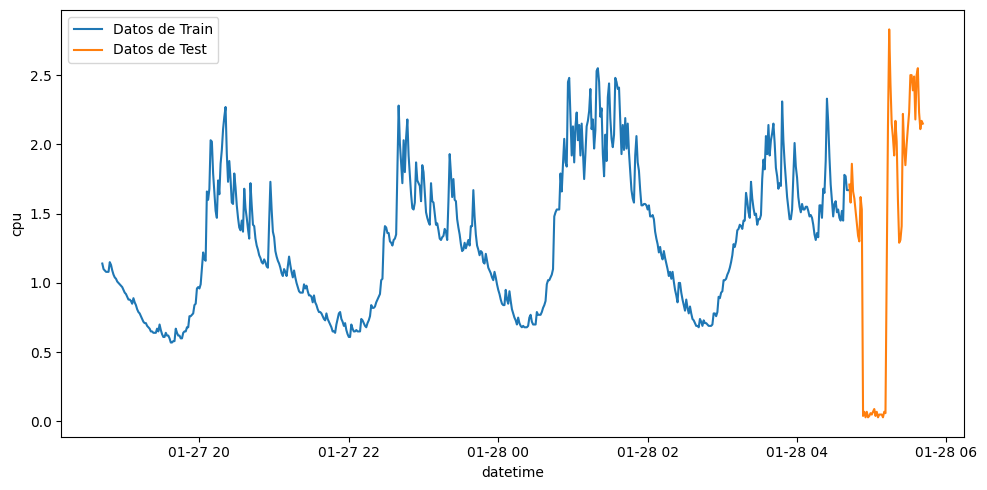

In [23]:
#ploteamos train y test

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data=ts_train, label='Datos de Train')
sns.lineplot(data=ts_test, label='Datos de Test')

plt.tight_layout()

plt.show()

## Paso 2: Construye y analiza la serie temporal

In [8]:
#Descomposición de la serie

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts_train, period = 24)
decomposition

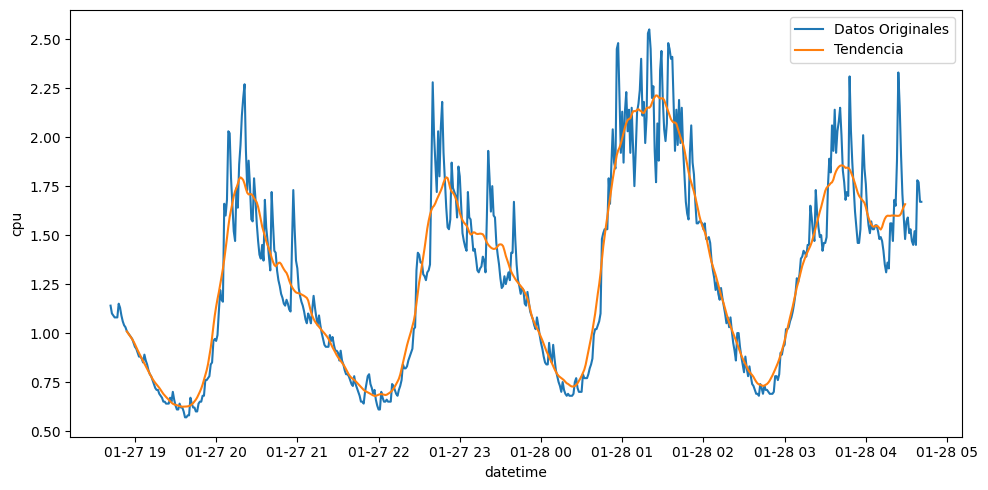

In [22]:
#Análisis de la tendencia - Trend analysis

trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_train, label = 'Datos Originales')
sns.lineplot(data = trend, label = 'Tendencia')


plt.tight_layout()

plt.show()

conclusiones:
- Vemos como se comporta la tendencia (test y naranja) en comparación con la serie original (train y azul)

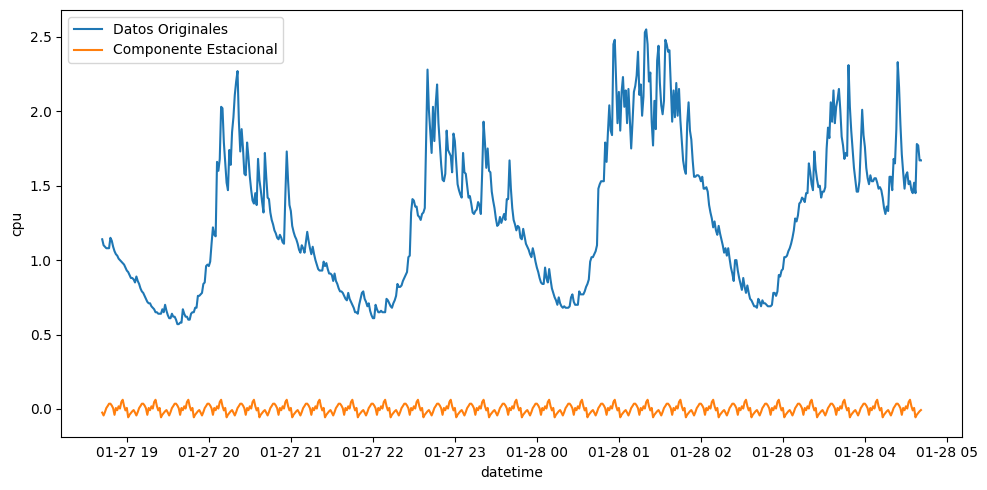

In [20]:
#Análisis de la estacionalidad - Seasonality analysis

seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_train, label = 'Datos Originales')
sns.lineplot(data = seasonal, label = 'Componente Estacional')

plt.tight_layout()

plt.show()

conclusiones:
- Vemos variaciones aleatorias en los datos por la gran cantidad de ruido que nos muestra test. Esto podria llevar a dificultad para obtener predicciones precisas o conclusiones incorrecta al finalizar el modelo. 

In [11]:
#Prueba de Dickey-Fuller (Dickey-Fuller test)

from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts_train)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                  -3.421625
p-value                          0.010243
#Lags Used                      18.000000
Number of Observations Used    581.000000
Critical Value (1%)             -3.441655
Critical Value (5%)             -2.866527
Critical Value (10%)            -2.569426
dtype: float64

conclusiones:
- el p-value es 0.010243, y como es menor que 0.05, podríamos rechazar la hipótesis nula y decir que es una serie estacionaria

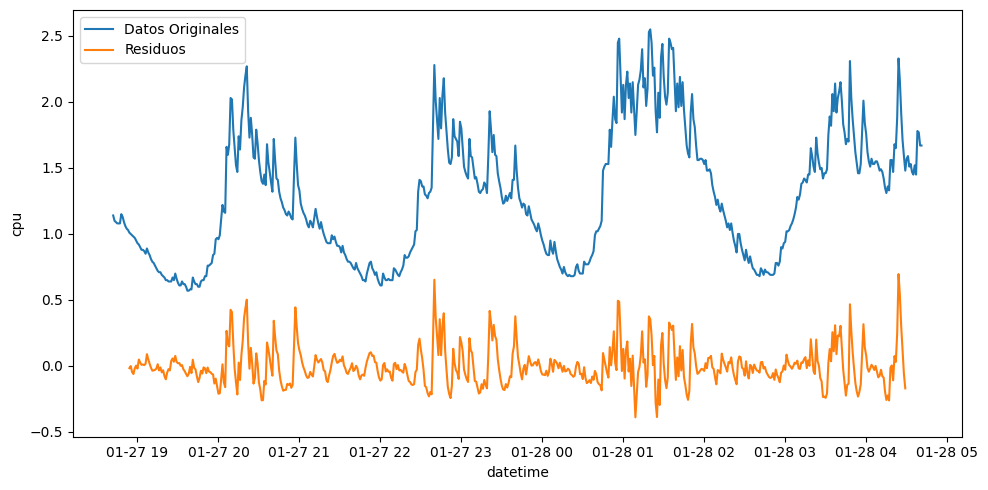

In [24]:
#Análisis de la variabilidad

residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data=ts_train, label='Datos Originales')
sns.lineplot(data=residual, label='Residuos')

plt.tight_layout()

plt.show()

conclusiones:
- tenemos ruido generalizado en todo el lineplot y esto puede dificultar la visualizacion del modelo

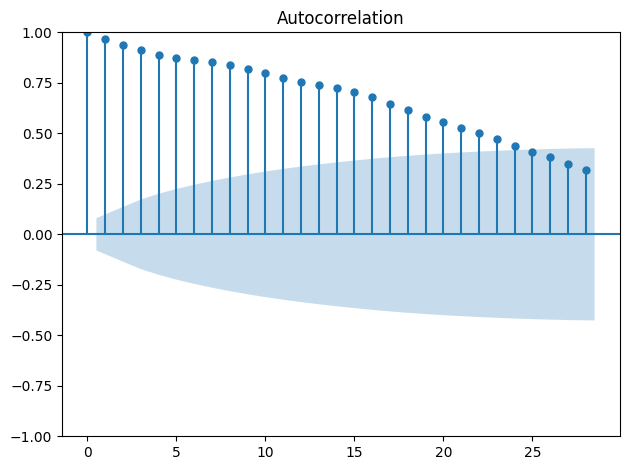

In [13]:
#Análisis de la autocorrelación

from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts_train)

plt.tight_layout()

plt.show()

conclusiones:
- la correlacion se va perdiendo con el tiempo por el tema del ruido. Los puntos finales casi no guardan correlacion con el modelo por lo que sera mas dificil precedir el modelo

## Paso 3: Entrenamiento del modelo con ARIMA

In [14]:
#para optimizar al máximo sus resultados, debemos transformar la serie en estacionaria

ts_stationary = ts_train.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -1.397789e+01
p-value                        4.229154e-26
#Lags Used                     4.000000e+00
Number of Observations Used    5.940000e+02
Critical Value (1%)           -3.441407e+00
Critical Value (5%)           -2.866418e+00
Critical Value (10%)          -2.569368e+00
dtype: float64

In [15]:
#aplicar el método ARIMA automático

from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 24)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[24] intercept   : AIC=inf, Time=6.93 sec
 ARIMA(0,0,0)(0,0,0)[24] intercept   : AIC=-812.814, Time=0.15 sec
 ARIMA(1,0,0)(1,0,0)[24] intercept   : AIC=-809.989, Time=1.07 sec
 ARIMA(0,0,1)(0,0,1)[24] intercept   : AIC=-810.139, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[24]             : AIC=-814.783, Time=0.07 sec
 ARIMA(0,0,0)(1,0,0)[24] intercept   : AIC=-811.059, Time=0.75 sec
 ARIMA(0,0,0)(0,0,1)[24] intercept   : AIC=-811.046, Time=0.97 sec
 ARIMA(0,0,0)(1,0,1)[24] intercept   : AIC=-809.013, Time=0.77 sec
 ARIMA(1,0,0)(0,0,0)[24] intercept   : AIC=-811.743, Time=0.13 sec
 ARIMA(0,0,1)(0,0,0)[24] intercept   : AIC=-811.910, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[24] intercept   : AIC=inf, Time=0.66 sec

Best model:  ARIMA(0,0,0)(0,0,0)[24]          
Total fit time: 12.787 seconds


conclusiones:
- nos sale el mejor modelo ARIMA(0,0,0)

In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  599
Model:                        SARIMAX   Log Likelihood                 408.391
Date:                Sat, 05 Aug 2023   AIC                           -814.783
Time:                        20:16:25   BIC                           -810.387
Sample:                    01-27-2017   HQIC                          -813.071
                         - 01-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0150      0.000     30.648      0.000       0.014       0.016
===================================================================================
Ljung-Box (L1) (Q):                   0.93   Jarque-Bera (JB):               611.96
Prob(Q):                              0.33   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                             1.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
#Predicción del modelo

forecast = model.predict(96)
forecast

2017-01-28 04:42:00    0.0
2017-01-28 04:43:00    0.0
2017-01-28 04:44:00    0.0
2017-01-28 04:45:00    0.0
2017-01-28 04:46:00    0.0
                      ... 
2017-01-28 06:13:00    0.0
2017-01-28 06:14:00    0.0
2017-01-28 06:15:00    0.0
2017-01-28 06:16:00    0.0
2017-01-28 06:17:00    0.0
Freq: T, Length: 96, dtype: float64

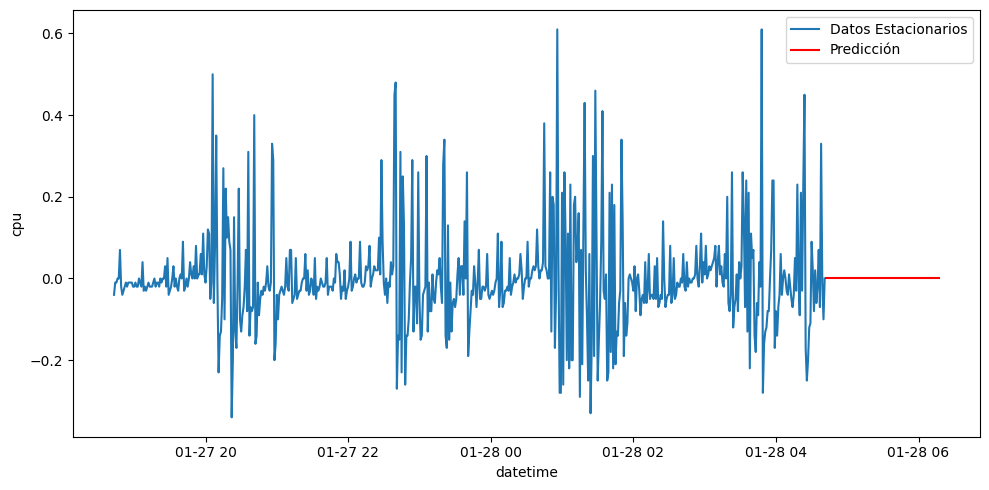

In [19]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary, label='Datos Estacionarios')
sns.lineplot(data = forecast, c = "red", label='Predicción')

plt.tight_layout()

plt.show()

conclusiones:
- Al haber tenido un ruido generalizado en todo el modelo y al ver el resultado en rojo en este lineplot, que es una linea plana, podemos decir que el modelo es un fracaso. Las soluciones serian usar tecnicas de suavizado o limpiar y corregir los datos para eleminar el ruido y tener un modelo mas preciso y en ascendencia 